# Unnecessary Complexity Through Layer Proliferation

In this blog, we continue to elaborate on our loosely `transformer`-based approach to training our computer to "understand" elementary symbolic arithmetic. Just as previously mentioned, a quick and fun intro to the venerable transformer is [here](http://jalammar.github.io/illustrated-transformer/).

Our objective is to expand our layers' repertoire to include the `encoder` and the `decoder` stacks, as well as to ultimately arrive at a model representable by the [graph](./layers.pdf).

We need to prep our environment to run any meaningful code:

In [1]:
import numpy as np
import tensorflow as tf
import dataset as qd
import ragged as qr
ks = tf.keras
kl = ks.layers

Before we start to focus on our stacks, an important feature of encoding textual inputs needs to be considered. To aid in making sense of a text, we need to include not just the information carried by the tokens themselves but also their position in the input sequence.

Following the "positional encoding" approach from [here](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb), we can define our `pos_timing` function as follows.

The quick graphical plot helps us confirm the correctness of our code as the concatenated `sin` and `cos` timing signals give us finely graded and rich positional embeddings:

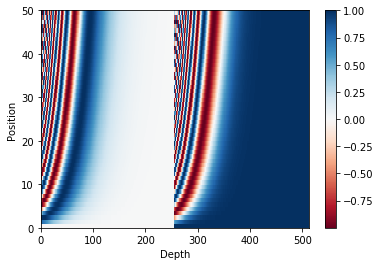

In [3]:
def pos_timing(width, depth):
    assert depth % 2 == 0
    d = np.arange(depth)[np.newaxis, :]
    d = 1 / np.power(10000, (2 * (d // 2)) / np.float32(depth))
    t = np.arange(width)[:, np.newaxis] * d
    t = [np.sin(t[:, 0::2]), np.cos(t[:, 1::2])]
    t = np.concatenate(t, axis=-1)[np.newaxis, ...]
    return t

pos = pos_timing(50, 512)

import matplotlib.pyplot as plt
plt.pcolormesh(pos[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Loading our already created meta data from the source files gives us:

In [4]:
print(qd.vocab)

(' ', ':', '|', 'x', 'y', '=', ',', '+', '-', '*', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


We continue with defining our own shared Keras "base" layer.

At this time, we only store a reference to our parameters instance in it, as all our layers will need to use this resource:

In [7]:
class Layer(kl.Layer):
    def __init__(self, ps, **kw):
        kw.setdefault('dtype', tf.float32)
        super().__init__(**kw)
        self.ps = ps

The `Embed` layer is taken directly from our previous blog.

As we need to add the above mentioned positional "timing signals" to our embeddings, we first create just such a `constant` tensor.

Then, using the previously mentioned `RaggedTensor`-technique of extracting the ragged-shaped values from a dense tensor, we simply add the positional info to the already determined embedding:

In [8]:
class Embed(Layer):
    def __init__(self, ps):
        super().__init__(ps)
        s = (ps.dim_vocab, ps.dim_hidden)
        self.emb = self.add_weight(name='emb', shape=s)
        p = pos_timing(ps.len_max_input, ps.dim_hidden)
        p = tf.constant(p, dtype=tf.float32)
        self.pos = tf.broadcast_to(p, [ps.dim_batch] + p.shape[1:])

    def call(self, x):
        fv, rs = x
        x = tf.RaggedTensor.from_row_splits(fv, rs)
        y = tf.ragged.map_flat_values(tf.nn.embedding_lookup, self.emb, x)
        y += tf.RaggedTensor.from_tensor(self.pos, lengths=y.row_lengths())
        return y

The next layers to write are the `Encode` and `Decode` stacks.

We implement them as simple lists of the respective `Encoder` and `Decoder` components. When calling the stacks, the code simply loops through the component lists and calls the components.

In order to "chain" the stacks, every component is given the output of the previous component as its input.

In the case of the `Decoder` components, and in addition to their regular inputs, we also supply the previously encoded output as their `ctx` argument:

In [9]:
class Encode(Layer):
    def __init__(self, ps):
        super().__init__(ps)
        self.encs = [Encoder(self, f'enc_{i}') for i in range(ps.dim_stacks)]

    def call(self, x):
        y = x
        for e in self.encs:
            y, ctx = e(y)
        return [y, ctx]

class Decode(Layer):
    def __init__(self, ps):
        super().__init__(ps)
        self.decs = [Decoder(self, f'dec_{i}') for i in range(ps.dim_stacks)]

    def call(self, x):
        y, ctx = x
        for d in self.decs:
            y = d([y, ctx])
        return y

The mirror "image" of the `Embed` layer is our `Debed` layer.

While the embedding step maps `int` tokens to higher-dimensional, learned `float` values, the "debedding" step does the opposite. It takes the higher-dimensional values and maps them to learned `one-hot` vectors, corresponding to approximate output tokens.

As debedding is implemented using a `Dense` component, it also requires a fixed width. Just as in the previous blog, we simply pad our ragged tensors with `0`s to our `len_max_input` parameter, as our calculations are complete and the raggedness is not needed any longer:

In [10]:
class Debed(Layer):
    def __init__(self, ps):
        super().__init__(ps)
        self.max_len = u = ps.len_max_input
        s = [u * ps.dim_hidden, ps.dim_vocab]
        self.dbd = Dense(self, 'dbd', s)

    def call(self, x):
        y = x.to_tensor()
        s = tf.shape(y)
        y = tf.pad(y, [[0, 0], [0, self.max_len - s[-2]], [0, 0]])
        y = tf.reshape(y, [-1, self.max_len * s[-1]])
        y = self.dbd(y)
        return y

We have now completed the definition of our top layers as Keras layers, but we still need to define the inner components.

We could continue using the seemingly "heavy" Keras layers and nest them deeper. Instead, as presented in a previous blog, we switch over to using the much lighter-weight `Module` as the base class for our inner components.

Our `Encoder` thus becomes a simple module containing the self-attention followed by the feed-forward mechanisms. We fittingly call the inner modules `reflect` and `conclude`.

Our `Decoder` also adds the attention layer looking at the previously encoded "context". Hence, the module encapsulating this attention component is called `consider`:

In [11]:
class Encoder(tf.Module):
    def __init__(self, layer, name=None):
        super().__init__(name=name)
        with self.name_scope:
            self.reflect = Attention(layer, 'refl')
            self.conclude = Conclusion(layer, 'conc')

    @tf.Module.with_name_scope
    def __call__(self, x):
        y, ctx = self.reflect([x, None])
        y = self.conclude(y)
        return [y, ctx]

class Decoder(tf.Module):
    def __init__(self, layer, name=None):
        super().__init__(name=name)
        with self.name_scope:
            self.reflect = Attention(layer, 'refl')
            self.consider = Attention(layer, 'cnsd')
            self.conclude = Conclusion(layer, 'conc')

    @tf.Module.with_name_scope
    def __call__(self, x):
        x, ctx = x
        y, _ = self.reflect([x, None])
        y, _ = self.consider([y, ctx])
        y = self.conclude(y)
        return y

Our `Attention` component, again based on `Module`, is taken directly from the previous blog. As explained there, it relies on and takes advantage of the new `RaggedTensor`s:

In [12]:
class Attention(tf.Module):
    def __init__(self, layer, name):
        super().__init__(name=name)
        h = layer.ps.dim_hidden
        self.scale = 1 / (h**0.5)
        with self.name_scope:
            self.q = layer.add_weight('q', shape=(h, h))
            self.k = layer.add_weight('k', shape=(h, h))
            self.v = layer.add_weight('v', shape=(h, h))

    @tf.Module.with_name_scope
    def __call__(self, x):
        x, ctx = x
        q = x.with_values(tf.einsum('ni,ij->nj', x.flat_values, self.q))
        k = x.with_values(tf.einsum('ni,ij->nj', x.flat_values, self.k))
        v = x.with_values(tf.einsum('ni,ij->nj', x.flat_values, self.v))
        y = tf.einsum('bsi,bzi->bsz', q.to_tensor(), k.to_tensor())
        y = tf.nn.softmax(y * self.scale)
        y = tf.einsum('bsz,bzi->bsi', y, v.to_tensor())
        y = tf.RaggedTensor.from_tensor(y, lengths=x.row_lengths())
        return [y, tf.constant(1)]

A new component is our `Conclusion` module. It implements the "feed-forward" functionality of the transformer.

In simple terms, it takes the attention-enhanced, higher-dimensional, element-wise mapping of the token sequence and it first `inflates` it to an even higher dimension with a non-linearity, or `activation`, at the end as its "concluding" step.

Then it `deflates` the activated mapping back to our hidden dimension, making it available for the next level in the stack.

The same `RaggedTensor` trick, as the one we used in the `Attention` module, applies at the end:

In [13]:
class Conclusion(tf.Module):
    def __init__(self, layer, name):
        super().__init__(name=name)
        ps = layer.ps
        self.max_len = w = ps.len_max_input
        w *= ps.dim_hidden
        with self.name_scope:
            s = [w, ps.dim_dense]
            self.inflate = Dense(layer, 'infl', s, activation='relu')
            s = [ps.dim_dense, w]
            self.deflate = Dense(layer, 'defl', s, bias=False)

    @tf.Module.with_name_scope
    def __call__(self, x):
        y = x.to_tensor()
        s = tf.shape(y)
        y = tf.pad(y, [[0, 0], [0, self.max_len - s[-2]], [0, 0]])
        y = tf.reshape(y, [-1, self.max_len * s[-1]])
        y = self.inflate(y)
        y = self.deflate(y)
        y = tf.reshape(y, [-1, self.max_len, s[-1]])
        y = tf.RaggedTensor.from_tensor(y, lengths=x.row_lengths())
        return y

Our last component is the `Dense` module.

It simply re-implements the Keras layer with the same name, yet with more focused, streamlined functionality and minimal configurability.

The interesting aspect of this module, just as our `Attention` module above, is that the necessarily created Keras weights are added using the enclosing Keras layer, however, topologically, they are directly listed as part of their respective modules:

In [14]:
class Dense(tf.Module):
    bias = None
    activation = None

    def __init__(self, layer, name, shape, activation=None, bias=True):
        super().__init__(name=name)
        with self.name_scope:
            kw = dict(shape=shape, initializer='glorot_uniform')
            self.kern = layer.add_weight('kern', **kw)
            if bias:
                kw.update(shape=shape[1:], initializer='zeros')
                self.bias = layer.add_weight('bias', **kw)
            self.activation = ks.activations.get(activation)

    @tf.Module.with_name_scope
    def __call__(self, x):
        y = tf.einsum('bi,ij->bj', x, self.kern)
        if self.bias is not None:
            y = tf.nn.bias_add(y, self.bias)
        if self.activation:
            y = self.activation(y)
        return y

And now we are ready to define our model.

We have the two inputs, the two components of our input `RaggedTensor`.

We also use our new `Embed`, `Encode`, `Decode` and `Debed` Keras layers, with all the internal, light-weight modules hidden at this level.

The rest of the model is simply carried over from the previous blog:

In [15]:
def model_for(ps):
    x = [ks.Input(shape=(), dtype='int32'), ks.Input(shape=(), dtype='int64')]
    y = Embed(ps)(x)
    y = Encode(ps)(y)
    y = Decode(ps)(y)
    y = Debed(ps)(y)
    m = ks.Model(inputs=x, outputs=y)
    m.compile(optimizer=ps.optimizer, loss=ps.loss, metrics=[ps.metric])
    print(m.summary())
    return m

Our parameters need to be adjusted to provide parametric values for our stacks:

In [16]:
params = dict(
    dim_batch=2,
    dim_dense=150,
    dim_hidden=6,
    dim_stacks=2,
    dim_vocab=len(qd.vocab),
    len_max_input=20,
    loss=ks.losses.SparseCategoricalCrossentropy(from_logits=True),
    metric=ks.metrics.SparseCategoricalAccuracy(),
    num_epochs=5,
    num_shards=2,
    optimizer=ks.optimizers.Adam(),
)

By firing up our training session, we can confirm the model's layers and connections. The listing of a short session follows.

We can easily adjust the parameters to tailor the length of the sessions to our objectives. However, at this point the results are still largely meaningless and extending the trainings is not yet warranted.

In [20]:
ps = qd.Params(**params)
import masking as qm
qm.main_graph(ps, qr.dset_for(ps), model_for(ps))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
embed_2 (Embed)                 (None, None, 6)      120         input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
encode_2 (Encode)               [(None, None, None), 72516       embed_2[0][0]              

With our TensorBoard `callback` in place, the model's `fit` method will generate the standard summaries that TB can conveniently visualize.

If you haven't run the code below, an already generated graph is [here](./layers.pdf).

In [1]:
#%load_ext tensorboard
#%tensorboard --logdir /tmp/q/logs

We can also switch over to the new `eager` execution mode.

This is particularly convenient for experimentation, as all ops are immediately executed. Here is a much shortened `eager` session:

In [21]:
ps.num_epochs = 1
qr.main_eager(ps, qr.dset_for(ps).take(100), model_for(ps))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
embed_3 (Embed)                 (None, None, 6)      120         input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
encode_3 (Encode)               [(None, None, None), 72516       embed_3[0][0]              

This concludes our blog, please see how to further customize our model by clicking on the next blog.